In [158]:
import Pkg
#Pkg.add("StatsBase")
#Pkg.add("Distributions")
#Pkg.add("GraphPlot")
#Pkg.add("Plots")
#Pkg.add("GraphRecipes")
#Pkg.add("NetworkLayout")
#Pkg.add("GeometryTypes")
#Pkg.add("PaddedViews")
#Pkg.add("Cairo")
#Pkg.add("Compose")
#Pkg.add("Plots")
#Pkg.add("PyPlot")
using StatsBase
using Random
using Distributions
using LinearAlgebra
using LightGraphs
#using LightGraphs: smallgraph
using GraphPlot
#using GraphRecipes, Plots
#using NetworkLayout:SFDP
#using GeometryTypes
using PaddedViews
using Cairo, Compose
using Plots
ENV["PYTHON"] = raw"C:\Python38\python.exe" 
Pkg.build("PyCall")
using PyCall
pyplot() #change backend

#Pkg.add("JuMP")
#Pkg.add("GLPK")
using JuMP
using GLPK

   Building Conda ─→ `C:\Users\Bastiiii\.julia\packages\Conda\x5ml4\deps\build.log`
   Building PyCall → `C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\deps\build.log`


In [159]:
"""
ForSample function https://github.com/JuliaStats/StatsBase.jl/blob/08d4b77a4b42ef8cadb67b98da65e7fbd9959e0b/src/sampling.jl#L445-L456

In our code, we use a simple sample fucntion, which has a stucture below
## sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false) ##

For weight factors [wv::AbstractWeights], please see https://juliastats.org/StatsBase.jl/stable/weights/
There are different weight vectors. the type of weight in our code is Probability weights.
(https://juliastats.org/StatsBase.jl/stable/weights/#ProbabilityWeights-1)
Attention!
U need delcare you weight type in the sample function or the sample function will not take it as a valid input
##
example:(this is invalid) ✘ the right one is in our code.
sample(Grid_Label_flatten::AbstractArray,✘final_probability_flatten✘, amount_panel , replace = false, ordered= true)
##
"""

"""
function Make_Question(n::Int,m::Int,factor::Int = 10, Density::Float64 = 0.8, option::String = "1-norm", distance::Int = 1)
    Grid_Label =  transpose( reshape(  collect(1:n*m),(n,m) ) )
    Grid_Label_flatten = reshape(Grid_Label,(m*n))
    
    px = abs.(((Grid_Label.-1) .% n).-((n-1)/2) )
    py = abs.(((Grid_Label.-1) .÷ n).-((n-1)/2))
    mesh_porbability = factor .^ -(px.+py)
    final_probability = mesh_porbability / sum(mesh_porbability)
    final_probability_flatten= reshape(final_probability, (m*n))
    
    amount_panel = Int(round(Density*n*m))
    
    allocation = sample(Grid_Label_flatten::AbstractArray, ProbabilityWeights(final_probability_flatten), amount_panel , replace = false, ordered= true)
    
    position_y = (allocation.-1).÷ n
    position_x = (allocation.-1).% n
    
    """
    make pairs to such structure to calculate the norm (for instance)
    2×32 Transpose{Int64,Array{Int64,2}}: 
     0  0  0  1  1  1  1  2  2  2  2  3  3  …  4  4  4  5  5  5  5  5  6  6  6  7
     2  3  4  2  3  4  5  2  3  4  5  0  1     3  4  5  0  2  3  4  5  1  2  4  0
    """
    position_pairs_pre = transpose(hcat(position_x,position_y))
    position_pairs = reshape(position_pairs_pre, (1 ,2 ,size(position_x)[1]))
    
    node_number = size(position_x)[1]
    Vector_2d_distance_set = zeros((1,2,node_number,node_number))
    [Vector_2d_distance_set[:,:,:,index] .= position_pairs .- position_pairs[:,:,index] for index in 1:node_number]
    
    norm_distance_set = zeros((node_number,node_number))
    if option == "1-norm"
        
        [norm_distance_set[index,:] .= [norm(slice,1) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    
    elseif option == "2-norm"
    
        [norm_distance_set[index,:] .= [norm(slice,2) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    else
        println("wrong input pal~")
        return 0
    end

    
    
    
    #network_adv = norm_distance_set .<= distance
    
    #nodelabel = collect(1:node_number+1).-1
    
    #network = network_adv - I
    
    # In order to be align with python style, add node and padding 1 and 0 to left and top in sequence.  
        #      vertices  x0t|
        #     0 | 0 | 0 | 0 | 
   #vertices' 1 | * | * | * | Left 1
        #     1 | * | o | o | 
        #x0t  1 | * | o | o | 
        #    Top 2
   
    network_expand_left = collect(PaddedView(1, network, (1:node_number, 0:node_number)))
    
    #display(network_expand_left)
    
    network_expand_bottom = collect(PaddedView(0, network_expand_left, (0:node_number , 1:node_number+1 )))
    
    #display(network_expand_bottom)
    
    complete_network = network_expand_bottom
   
    pos = Dict()
    pos[0] = (1.2*m-0.5,1.2*n)
    for n in 1:length(position_x)
        pos[n] = (position_x[n],position_y[n])
    end
    
    
    return complete_network,allocation,node_number,pos , nodelabel;
end

"""

LoadError: syntax: extra token "pairs" after end of expression

In [160]:
py"""
def Make_Question(n, m, factor=10, Density = 0.75, option = "1-norm", distance = 2):
    nx, ny = (n, m)
    x = np.arange(nx,dtype=float)
    y = np.arange(ny,dtype=float)
    xv, yv = np.meshgrid(x, y)
    Px = np.power(factor,-np.abs(xv-(n-1)/2))
    Py = np.power(factor,-np.abs(yv-(m-1)/2))
    mesh_porbability = np.multiply(Px,Py)
    final_probability = np.multiply(Px,Py)/np.sum(mesh_porbability)
    amount_panel = np.int(Density*n*m)
    allocation = np.random.choice(np.arange(n*m), amount_panel, replace=False, p = final_probability.flatten())
    x_position = allocation // m
    y_position = allocation %  m  
    
    vertices = np.vstack((x_position, y_position)).T
    vertices = vertices[np.lexsort((-vertices[:,0],-vertices[:,1]))]
    
    
    example = vertices[0]
    network = np.zeros((amount_panel,amount_panel))
    for i, vertex in enumerate(vertices):
        example = vertices[i]
        if option == "1-norm":
            # adjacent option
            index = np.where(np.sum(np.abs(vertices-example),axis = 1) == 1)
        elif option == "2-norm":
            # include diag or more
            index = np.where(np.linalg.norm(np.abs(vertices-example),axis = 1) < distance)
        else:
            print("error_input")
        network[i][index] = 1
        
    
    network_adv = np.triu(network, k=1)
    network_adv = network_adv + network_adv.T
    
    
    network_adv = np.pad(network_adv, ((1,0), (1,0)), 'constant', constant_values=((0, 0), (1, 0)))
    network_adv[0,0] = 0
    
    #print(vertices)
    pos = {0: (2*n+0.7,m * 2)} 
    for i, vertex in enumerate(vertices * 2):
        temp_pos = (vertex[0],vertex[1])
        pos.update({i+1: temp_pos})
    return network_adv,pos
"""

In [161]:
m = 3
n = 3
complete_network,pos = py"Make_Question"(n,m);



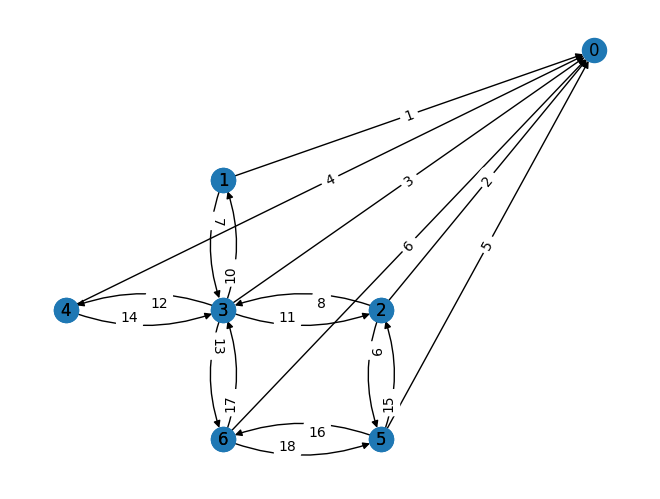

In [162]:
py"""
def complete_Graph (network,pos):
    # Draw the Directed Graph
    
    G = nx.DiGraph()
    G = nx.from_numpy_array(network,create_using=nx.DiGraph(directed=True))
    
    ##
    
    network_0 = network.copy()
    network_0[1:,1:] = 0
    
    G_0 = nx.DiGraph()
    G_0 = nx.from_numpy_array(network_0,create_using=nx.DiGraph(directed=True))
      
    nx.draw(G_0,pos,with_labels=True)
    
    edge_label = {}
    for j, edge in enumerate(G_0.edges()):
        edge_label.update({(edge[0],edge[1]): str(j+1)})
        
    graph = nx.draw_networkx_edge_labels(G_0,pos,edge_labels = edge_label)
    
    ##
    
    G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)
    
    ##
    edge_label.update(sub_edge_label)
    graph.update(sub_graph)
    
    return G, edge_label, graph

def sub_Graph (network,pos):
    G_prime = nx.DiGraph()
    G_prime = nx.from_numpy_array(network,create_using=nx.DiGraph(directed=True))
    G_prime.remove_node(0)
    
    
    # Label Edge with following rules:
    # 1. num(BUS)<num(branch)
    # 2. priority(BUS)>priority(branch)
    sub_edge_label = {}
    sub_edge_label_up = {}
    sub_edge_label_down = {}
    sub_edge_label_initial = {}
    
    for j, edge in enumerate(G_prime.edges()):
        if edge[1] > edge[0]:
            sub_edge_label_up.update({(edge[0],edge[1]): str(j+len(pos))})
        else:
            sub_edge_label_down.update({(edge[0],edge[1]): str(j+len(pos))})
        
    
    nx.draw(G_prime,pos,with_labels=True,connectionstyle='arc3, rad = 0.2')
    
    
    sub_edge_label.update(sub_edge_label_initial)
    sub_edge_label.update(sub_edge_label_up)
    sub_edge_label.update(sub_edge_label_down)
    
    sub_graph_initial = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_initial)
    sub_graph_up = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_up, label_pos = 0.65, verticalalignment = 'bottom',horizontalalignment = 'right')
    sub_graph_down = nx.draw_networkx_edge_labels(G_prime,pos,edge_labels = sub_edge_label_down, label_pos = 0.65, verticalalignment = 'top',horizontalalignment = 'left')

    sub_graph = {}
    sub_graph.update(sub_graph_initial)
    sub_graph.update(sub_graph_up)
    sub_graph.update(sub_graph_down)
    
    return G_prime, sub_edge_label, sub_graph

"""
G, compelete_label, graph = py"complete_Graph"(complete_network,pos);


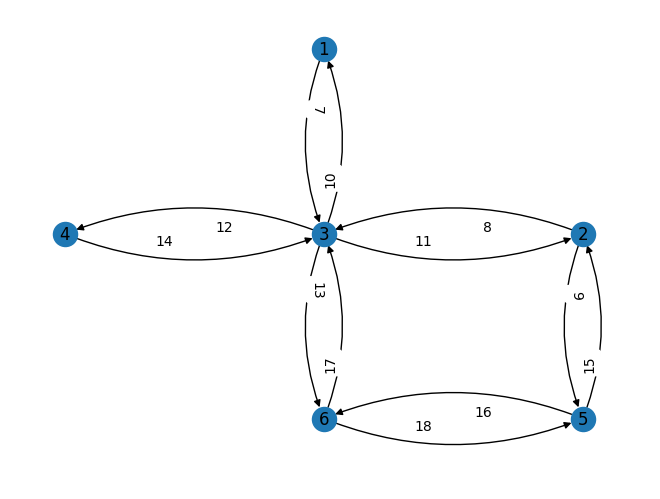

In [163]:
G_prime, sub_edge_label = py"sub_Graph"(complete_network,pos);

In [202]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def edge_map (G, compelete_label, sub_edge_label):
    
    lowest_edge = len(compelete_label) - len(sub_edge_label)

    complete_edge = np.asarray(G.edges())
    new_map = np.zeros((len(compelete_label),len(compelete_label)))
    #print(complete_edge)
    #print(complete_edge[:,0])
    for edge in sub_edge_label:
        
        #leaving edge       
        #map_index_0, _ = np.where(complete_edge[] == edge[0])
        #print(edge[0],edge[1])
        #print(np.where(complete_edge[:,0] == edge[1]))
                
        map_index_source = np.where(complete_edge[:,0] == edge[1])
        source_edge_index = np.int(compelete_label[(edge[0],edge[1])])-1
        
        for matched_index in map_index_source[0]:
            #print(matched_index)
            #print(complete_edge[matched_index][0],complete_edge[matched_index][1])
            to_edge_index = np.int(compelete_label[(complete_edge[matched_index][0],complete_edge[matched_index][1])])-1
            if to_edge_index >= lowest_edge: 
                new_map[source_edge_index][to_edge_index] = 1
            else
                new_map[source_edge_index][to_edge_index] = 0
        
        
    return new_map, lowest_edge
"""
Final_map, lowest_edge_number = py"edge_map"(G, compelete_label, sub_edge_label);

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\src\pyeval.jl:34 =# @pysym(:Py_CompileString), PyPtr, (Cstring, Cstring, Cint), s, fname, input_type))))) <class 'SyntaxError'>
SyntaxError('invalid syntax', ('C:\\Users\\Bastiiii\\.julia\\packages\\PyCall\\tqyST\\src\\pyeval.jl', 31, 17, '            else\n'))


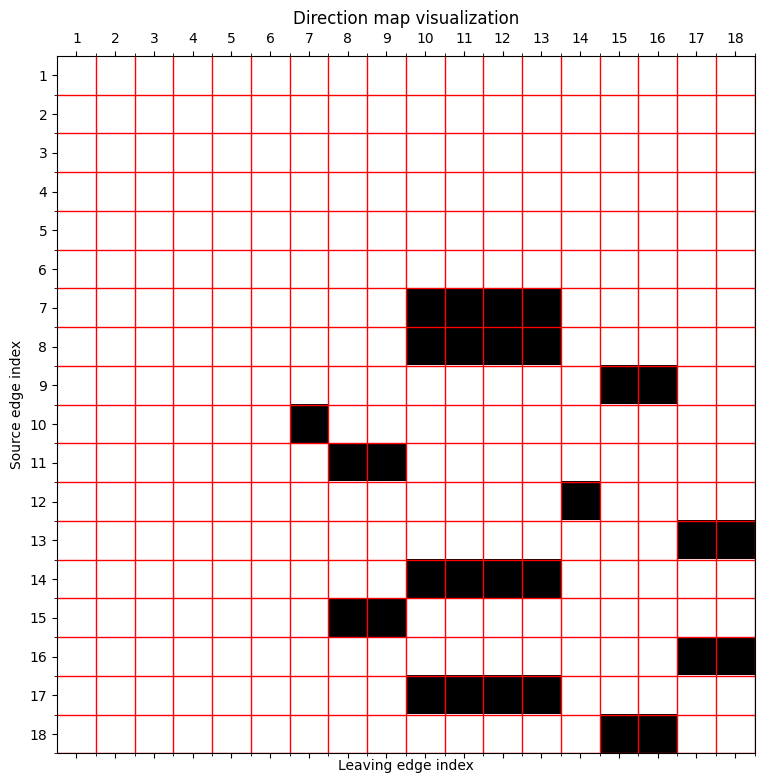

In [203]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

def Draw_edge_map (Final_map, lowest_edge_number,compelete_label,pos,G):
    matfig = plt.figure(figsize=(9,9))
    plt.matshow(Final_map,cmap=plt.cm.binary,fignum=matfig.number)
    ax = plt.gca()
    #plt.matshow(Final_map,cmap=plt.cm.binary)
    plt.xlabel('Leaving edge index')
    plt.ylabel('Source edge index')
    plt.title ("Direction map visualization")

    # Major ticks
    ax.set_xticks(np.arange(0, Final_map.shape[0], step=1))
    ax.set_yticks(np.arange(0, Final_map.shape[0], step=1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, Final_map.shape[0]+1, step=1))
    ax.set_yticklabels(np.arange(1, Final_map.shape[0]+1, step=1))

    # Minor ticks
    ax.set_xticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)
    ax.set_yticks(np.arange(0.5, Final_map.shape[0]+0.5, step=1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)
    
    

"""
py"Draw_edge_map"(Final_map, lowest_edge_number,compelete_label,pos,G)


# Quick note of plt.show() is kind of deprecated.
# .julia\packages\PyCall\tqyST\src\pyeval.jl:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
# @pycheckn ccall((@pysym :PyEval_EvalCode),

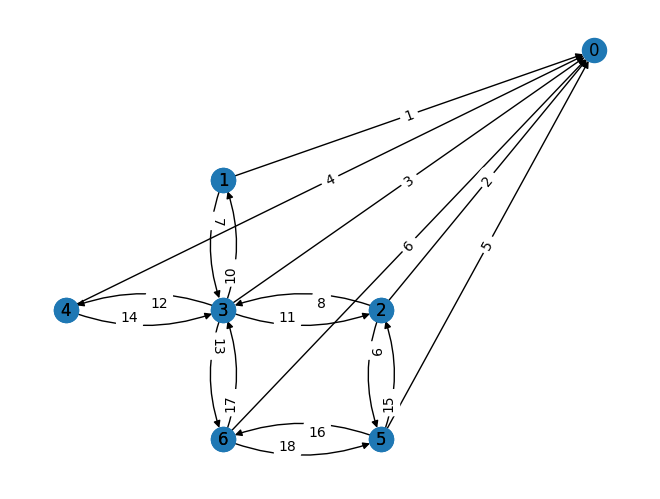

In [204]:
py"complete_Graph"(complete_network,pos);

In [205]:
lowest_edge_number

6

In [206]:
iout_map = [ findall( x ->  x > 0,Final_map[ie,:]) for ie in 1:size(Final_map)[1]]

18-element Array{Array{Int64,1},1}:
 []
 []
 []
 []
 []
 []
 [10, 11, 12, 13]
 [10, 11, 12, 13]
 [15, 16]
 [7]
 [8, 9]
 [14]
 [17, 18]
 [10, 11, 12, 13]
 [8, 9]
 [17, 18]
 [10, 11, 12, 13]
 [15, 16]

In [207]:
iin_map = [ findall( x ->  x > 0,Final_map[:,ie]) for ie in 1:size(Final_map)[1]]

18-element Array{Array{Int64,1},1}:
 []
 []
 []
 []
 []
 []
 [10]
 [11, 15]
 [11, 15]
 [7, 8, 14, 17]
 [7, 8, 14, 17]
 [7, 8, 14, 17]
 [7, 8, 14, 17]
 [12]
 [9, 18]
 [9, 18]
 [13, 16]
 [13, 16]

In [208]:
Q = length(allocation) 　
Edge_set = size(Final_map)[1]
c_e = 1
p =1
println(Q)
println(Edge_set)


7
18


In [212]:
using JuMP
using GLPK
model = Model(with_optimizer(GLPK.Optimizer))
@variable(model, x[1:Edge_set, 1 : Q], Bin)
    
@objective(model, Min, 
        sum(
            sum(
                c_e * x[ie,id]
            for ie = 1: Edge_set)
        for id = 1: Q)
        +
        p*sum(
            sum(
                (id-1) * c_e * x[ie,id]
            for ie =lowest_edge_number + 1 : Edge_set)
        for id = 1: Q)
        )

@constraint(model,c1[ie in lowest_edge_number+1:Edge_set], sum(sum(x[iout,id] for id =1 :Q) for iout in iout_map[ie]) == 1)
@constraint(model,c2[ie in lowest_edge_number+1:Edge_set], (sum(sum(id*x[iout,id] for id =1 :Q) for iout in iout_map[ie]) - sum(sum(id*x[iin,id] for id =1 :Q) for iin in iin_map[ie])) == 1)
#@constraint(model,c3,sum(sum(id*x[ie,id] for ie in 1:lowest_edge_number+1) for id in 1:Q)== Q)

#@constraint(model, c2, 7x + 12y >= 120)
print(model)


Min x[1,1] + x[2,1] + x[3,1] + x[4,1] + x[5,1] + x[6,1] + x[7,1] + x[8,1] + x[9,1] + x[10,1] + x[11,1] + x[12,1] + x[13,1] + x[14,1] + x[15,1] + x[16,1] + x[17,1] + x[18,1] + x[1,2] + x[2,2] + x[3,2] + x[4,2] + x[5,2] + x[6,2] + 2 x[7,2] + 2 x[8,2] + 2 x[9,2] + 2 x[10,2] + 2 x[11,2] + 2 x[12,2] + 2 x[13,2] + 2 x[14,2] + 2 x[15,2] + 2 x[16,2] + 2 x[17,2] + 2 x[18,2] + x[1,3] + x[2,3] + x[3,3] + x[4,3] + x[5,3] + x[6,3] + 3 x[7,3] + 3 x[8,3] + 3 x[9,3] + 3 x[10,3] + 3 x[11,3] + 3 x[12,3] + 3 x[13,3] + 3 x[14,3] + 3 x[15,3] + 3 x[16,3] + 3 x[17,3] + 3 x[18,3] + x[1,4] + x[2,4] + x[3,4] + x[4,4] + x[5,4] + x[6,4] + 4 x[7,4] + 4 x[8,4] + 4 x[9,4] + 4 x[10,4] + 4 x[11,4] + 4 x[12,4] + 4 x[13,4] + 4 x[14,4] + 4 x[15,4] + 4 x[16,4] + 4 x[17,4] + 4 x[18,4] + x[1,5] + x[2,5] + x[3,5] + x[4,5] + x[5,5] + x[6,5] + 5 x[7,5] + 5 x[8,5] + 5 x[9,5] + 5 x[10,5] + 5 x[11,5] + 5 x[12,5] + 5 x[13,5] + 5 x[14,5] + 5 x[15,5] + 5 x[16,5] + 5 x[17,5] + 5 x[18,5] + x[1,6] + x[2,6] + x[3,6] + x[4,6] + x[5,6] + 

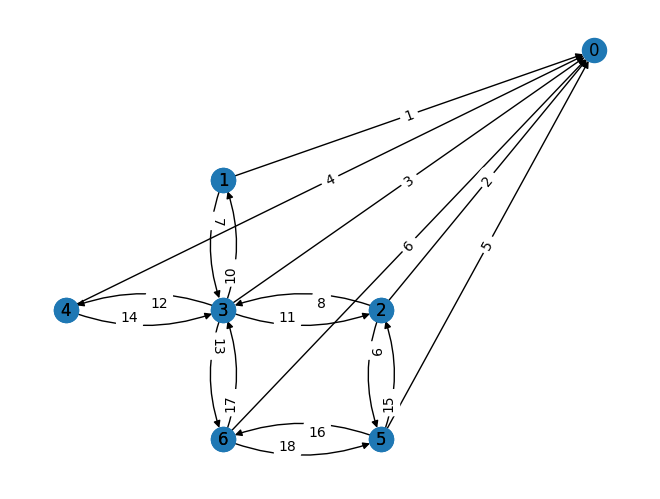

In [213]:
py"complete_Graph"(complete_network,pos);

In [214]:
optimize!(model)
@show termination_status(model)
#@show primal_status(model)
#@show dual_status(model)
@show objective_value(model)
@show JuMP.value.(x)
#@show shadow_price(c1)
#@show shadow_price(c2)

termination_status(model) = MathOptInterface.INFEASIBLE


MathOptInterface.ResultIndexBoundsError{MathOptInterface.ObjectiveValue}: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.

In [92]:
# 需要改的部分
#1、 Python 生成的边图应该保持方向性，虽然这样会double 边的数量
#2、注意 原论文公式2，3  i应该只覆盖比lowest_edge_number的edge的编号（白话说就是只统计双向边的进出流量） 
#3、应增添每个顶点的进出edge 的黑白图